In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import rsatoolbox

from privacy_and_grokking.models import MLP, CNN
from privacy_and_grokking.path_keeper import PathKeeper
from torchvision import transforms, datasets
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names

In [2]:
SEED = 64
NUM_CLASSES = 10
SAMPLES_PER_CLASS = 5

In [3]:
RUN_ID = "v1.2.4"
MODELS = [
    (RUN_ID, "MLP_GROK_V1", MLP, [100, 5000, 100000]),
    (RUN_ID, "MLP_V1", MLP, [100000]),
    (RUN_ID, "CNN_GROK_V1", CNN, [1000, 30000, 100000]),
    (RUN_ID, "CNN_V1", CNN, [100000]),
]

In [4]:
pk = PathKeeper()
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)), # MNIST mean/std
])

train = datasets.MNIST(
    root=pk.CACHE,
    train=True, 
    transform=transform,
    download=True
)
test = datasets.MNIST(
    root=pk.CACHE,
    train=False, 
    transform=transform,
    download=True
)

In [6]:
Samples = dict[int, list[torch.Tensor]]
def get_samples(dataset) -> Samples:
    class_indices = {i: [] for i in range(NUM_CLASSES)}

    for image, label in dataset:
        if len(class_indices[label]) < SAMPLES_PER_CLASS:
            class_indices[label].append(image)

        if all(len(indices) == SAMPLES_PER_CLASS for indices in class_indices.values()):
            break

    return class_indices

train_samples = get_samples(train)
test_samples = get_samples(test)

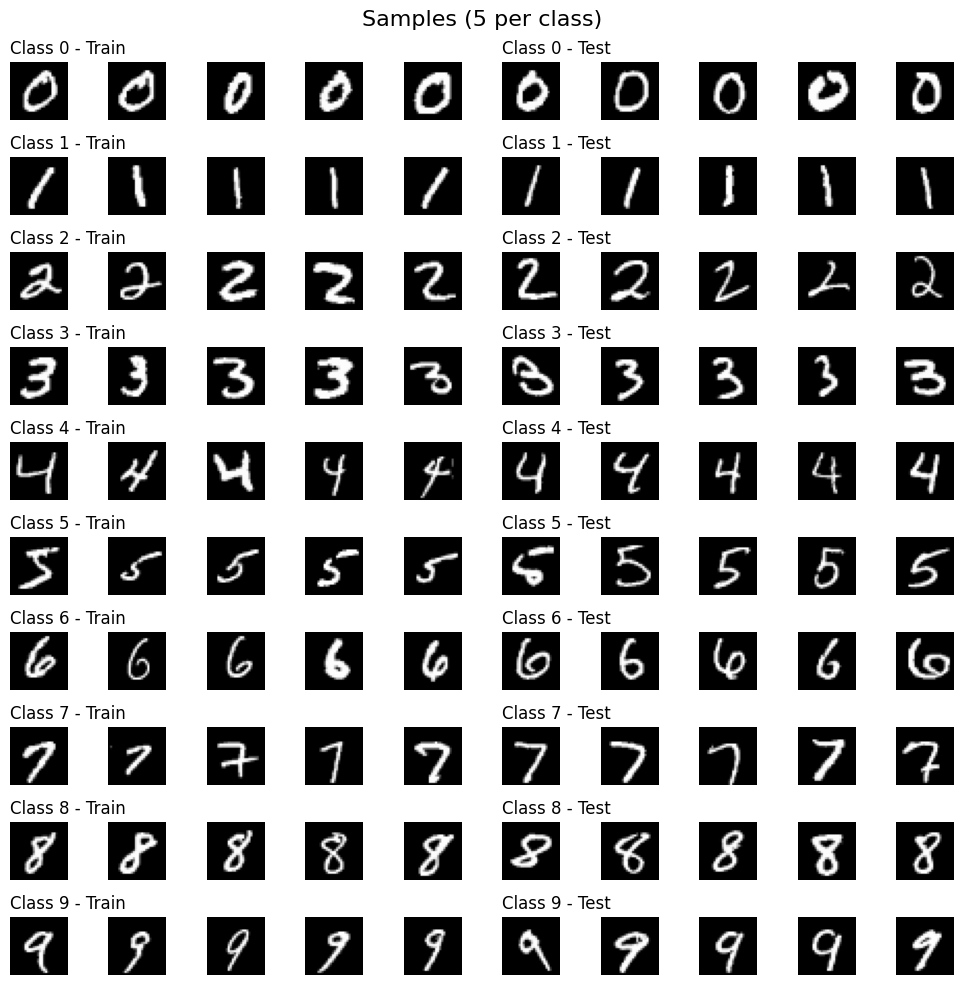

In [7]:
def display_images(train_samples: Samples, test_samples: Samples):
    fig, axes = plt.subplots(NUM_CLASSES, SAMPLES_PER_CLASS * 2, figsize=(10, 10))
    fig.suptitle(f"Samples ({SAMPLES_PER_CLASS} per class)", fontsize=16)

    for cls_idx in range(NUM_CLASSES):
        for offset in [0, 1]:
            samples = train_samples if offset == 0 else test_samples
            for sample_idx, image in enumerate(samples[cls_idx]):
                ax = axes[cls_idx, sample_idx + offset * SAMPLES_PER_CLASS]
                
                # Should we normalize back? - I don't see a difference.
                # image = image * 0.3081 + 0.1307
                ax_ = ax.imshow(image.squeeze(), cmap="gray")
                # ax.imshow(image.squeeze(), cmap="gray")
                ax.axis("off")
                if sample_idx == 0:
                    title = f"Class {cls_idx} - {'Train' if offset == 0 else 'Test'}"
                    ax.set_title(title, fontsize=12, loc="left")

    plt.tight_layout()
    plt.show()

display_images(train_samples, test_samples)

In [8]:
type RDMS = dict[str, np.ndarray]
def get_rdms(layer_measurement_dict: dict[str, np.ndarray], method='correlation') -> RDMS:
    datasets = []
    for layer, measurements in layer_measurement_dict.items():
        ds = rsatoolbox.data.Dataset(measurements.squeeze(), descriptors=dict(layer=layer))
        datasets.append(ds)

    rdms = rsatoolbox.rdm.calc_rdm(datasets, method=method)

    return {layer: rdms.get_matrices()[i] for i, (layer, _) in enumerate(layer_measurement_dict.items())}

def display_rdms(rdms: RDMS, title: str = "RDMs"):
    num_layers = len(rdms)
    fig, axes = plt.subplots(1, num_layers, figsize=(14, 4))
    fig.suptitle(title)
    gs = fig.add_gridspec(1, num_layers)

    for i, (layer, rdm) in enumerate(rdms.items()):
        ax = axes[i] if num_layers > 1 else axes
        im = ax.imshow(rdm / rdm.max(), cmap='magma_r')
        ax.set_title(layer, fontsize=12)

        ax.set_xlabel("Input Index")
        if i == 0:
            ax.set_ylabel("Input Index")

    cbar_ax = fig.add_axes([1, 0.17, 0.01, 0.58])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Dissimilarity', rotation=270, labelpad=15)

    plt.tight_layout()

/var/folders/_r/9n6ndj_d7k5b5yds9vn86n200000gn/T/ipykernel_61432/3747829132.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


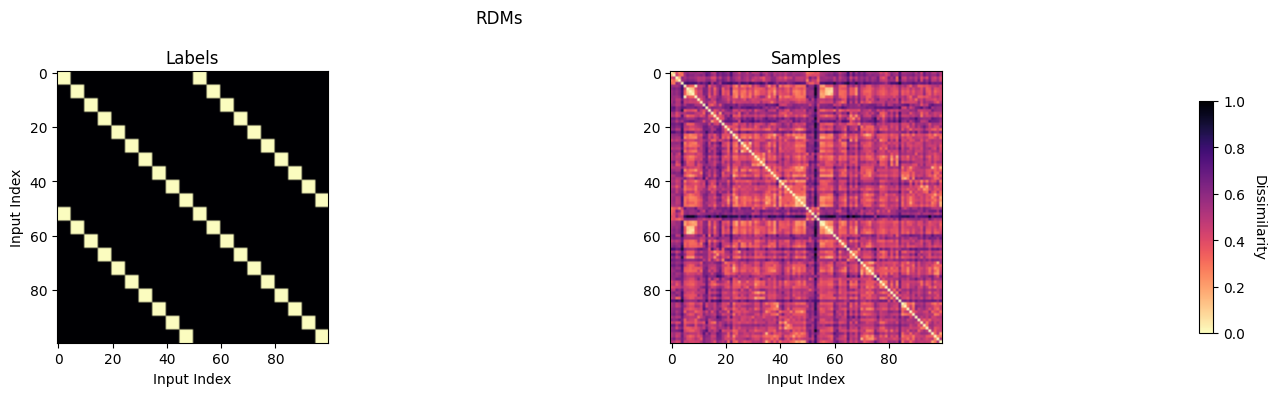

In [9]:
one_hot_labels = {
    "Labels": torch.nn.functional.one_hot(torch.tensor([i for _ in range(2) for i in range(NUM_CLASSES) for _ in range(SAMPLES_PER_CLASS)]), num_classes=10).numpy(),
    "Samples": np.array([img.squeeze().flatten().numpy() for imgs in train_samples.values() for img in imgs] + [img.squeeze().flatten().numpy() for imgs in test_samples.values() for img in imgs]),
    # "Test Samples": np.array([img.squeeze().flatten().numpy() for imgs in test_samples.values() for img in imgs]),
}
rdms_dict = get_rdms(one_hot_labels, method='euclidean')
display_rdms(rdms_dict)

In [10]:
def extract_features(model, imgs):
    return_layers, _ = get_graph_node_names(model)
    feature_extractor = create_feature_extractor(model, return_nodes=return_layers)
    model_features = feature_extractor(imgs)
    return model_features

In [11]:
images = torch.stack([img for imgs in train_samples.values() for img in imgs] +
                     [img for imgs in test_samples.values() for img in imgs])

/var/folders/_r/9n6ndj_d7k5b5yds9vn86n200000gn/T/ipykernel_61432/3747829132.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/_r/9n6ndj_d7k5b5yds9vn86n200000gn/T/ipykernel_61432/3747829132.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/_r/9n6ndj_d7k5b5yds9vn86n200000gn/T/ipykernel_61432/3747829132.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/_r/9n6ndj_d7k5b5yds9vn86n200000gn/T/ipykernel_61432/3747829132.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/_r/9n6ndj_d7k5b5yds9vn86n200000gn/T/ipykernel_61432/3747829132.py:31: UserWarning: This figure includes Axes that are n

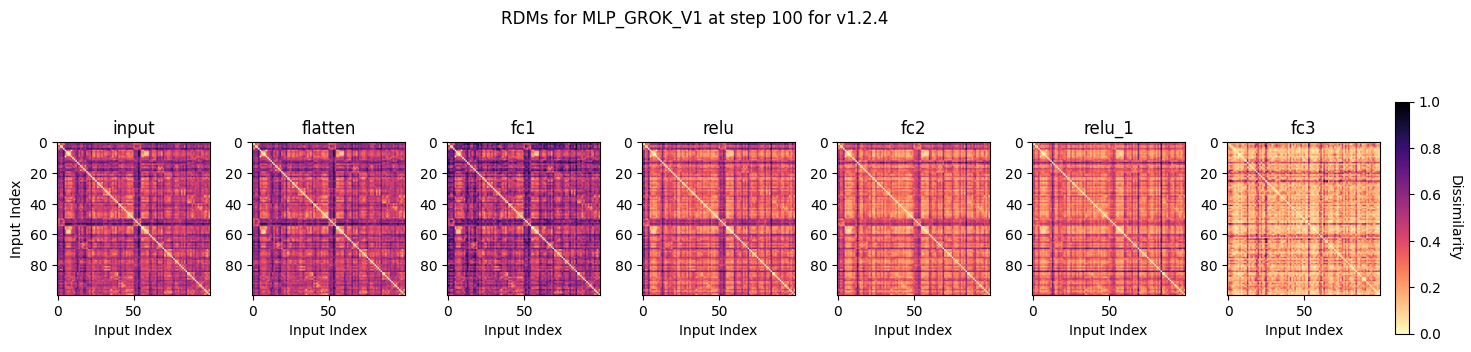

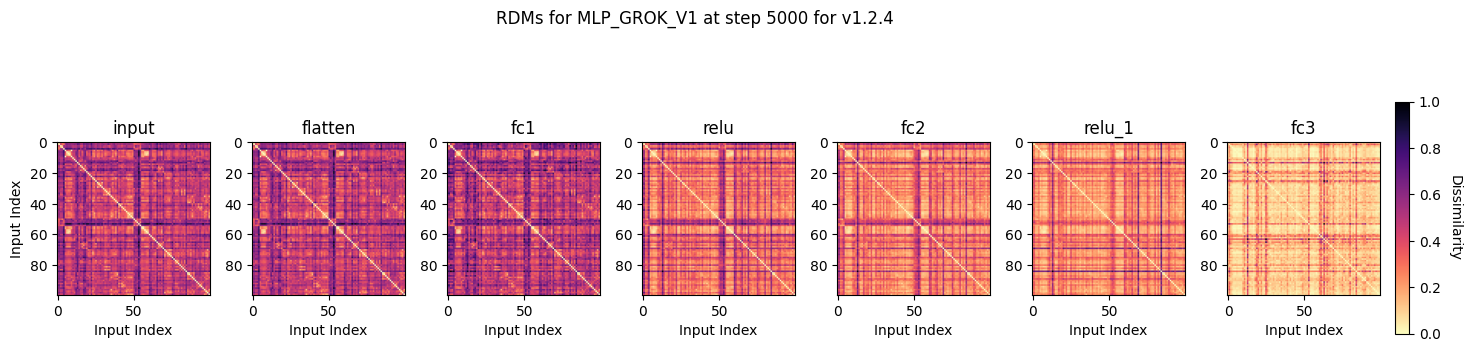

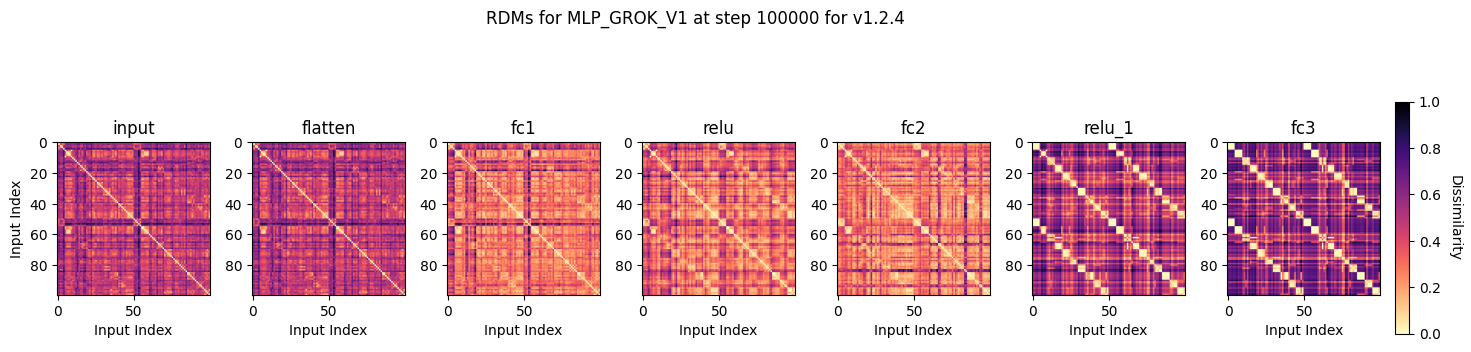

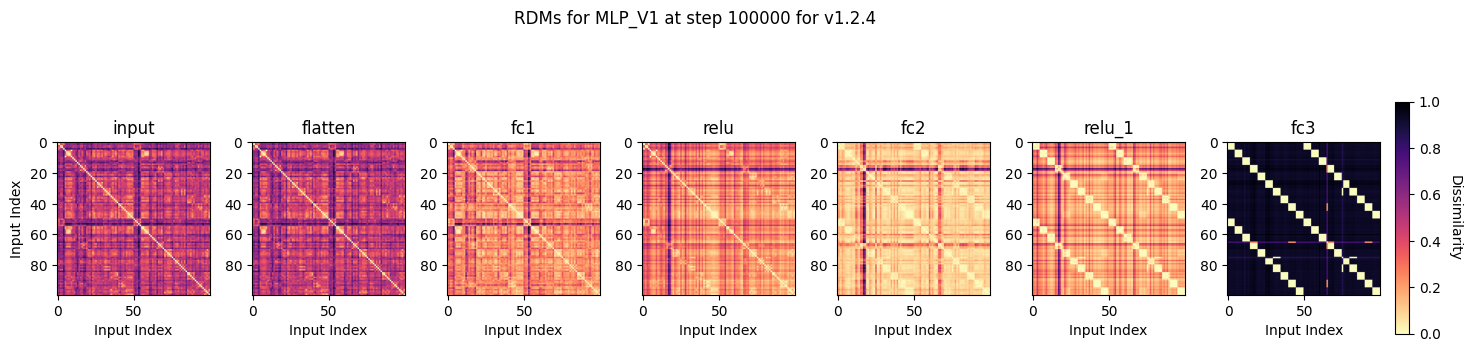

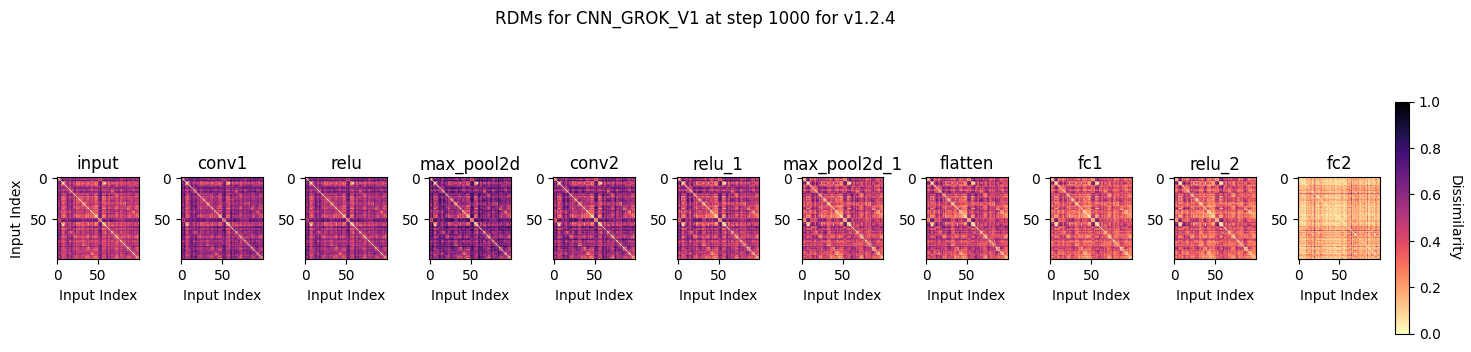

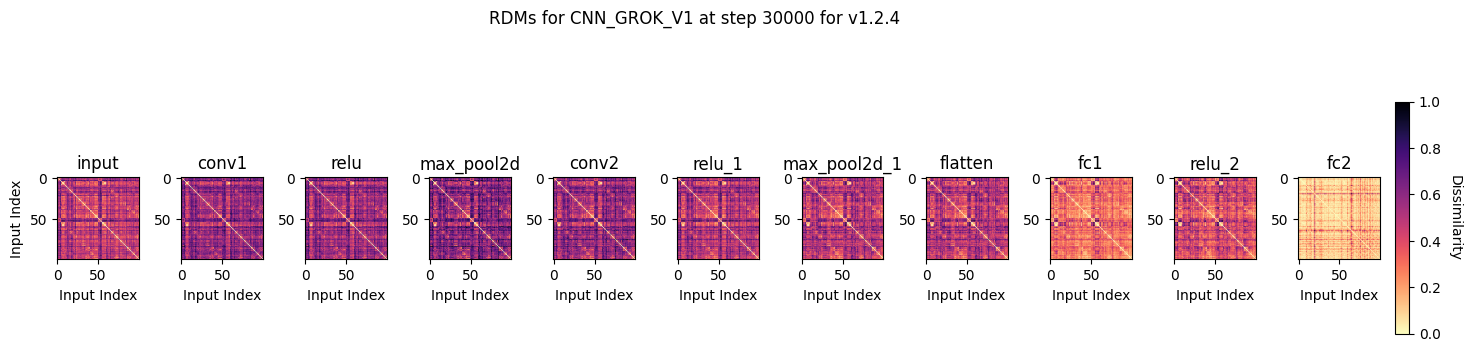

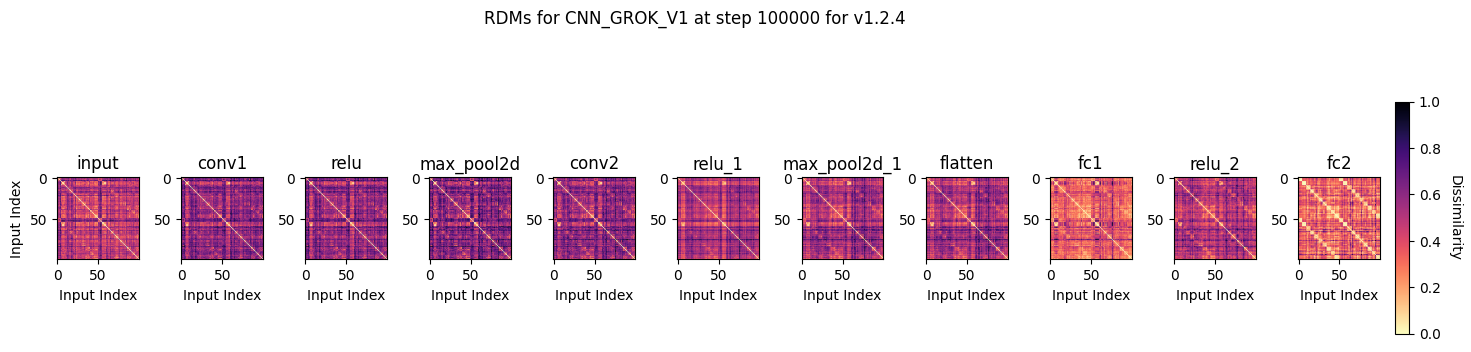

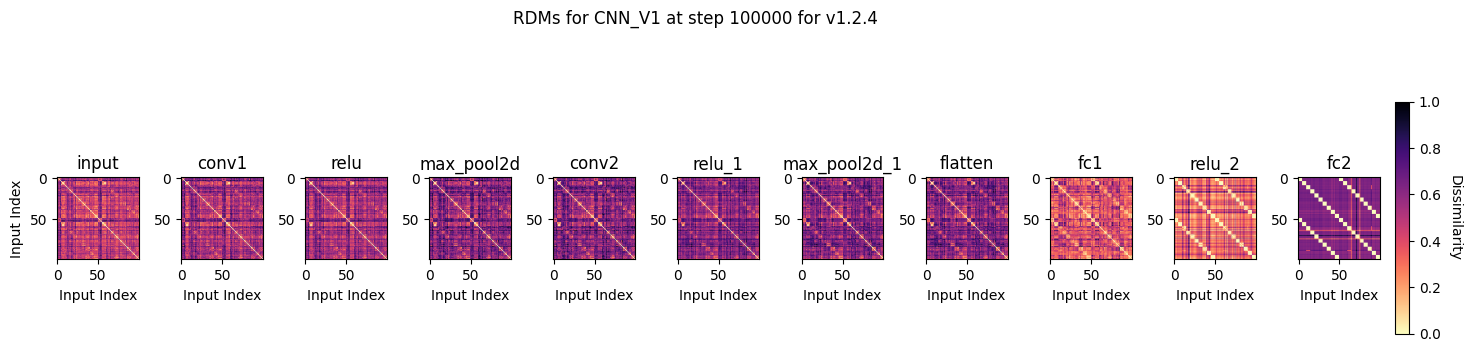

In [13]:
for run_id, model_name, ModelClass, steps in MODELS:
    for step in steps:
        pk.set_params({"run_id": run_id, "model": model_name, "step": str(step)})
        mdl = ModelClass()
        mdl.load_state_dict(torch.load(pk.MODEL_TORCH, weights_only=True, map_location=torch.device('cpu')))
        mdl.eval()
        extracted_features = extract_features(mdl, images)
        data = {label: measures.squeeze().flatten(1).detach().numpy() for label, measures in extracted_features.items()}
        rdms_dict = get_rdms(data, method='euclidean')
        display_rdms(rdms_dict, title=f"RDMs for {model_name} at step {step} for {run_id}")